In [33]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [34]:
!pip install tensorflow-gpu >> /dev/null

The system cannot find the path specified.


In [35]:
!pip install --upgrade grpcio >> /dev/null

The system cannot find the path specified.


In [36]:
!pip install tqdm  >> /dev/null.

The system cannot find the path specified.


In [37]:
#-conda create --name tensorflow
#python=3.5 activate tensorflow
!pip install tensorflow-gpu
!pip install tensorflow==2.0
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install sentencepiece
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0
ERROR: No matching distribution found for tensorflow==2.0


In [38]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [39]:
train.shape

(120000, 3)

In [40]:

train.head()

,Class Index,Title,Description
0,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


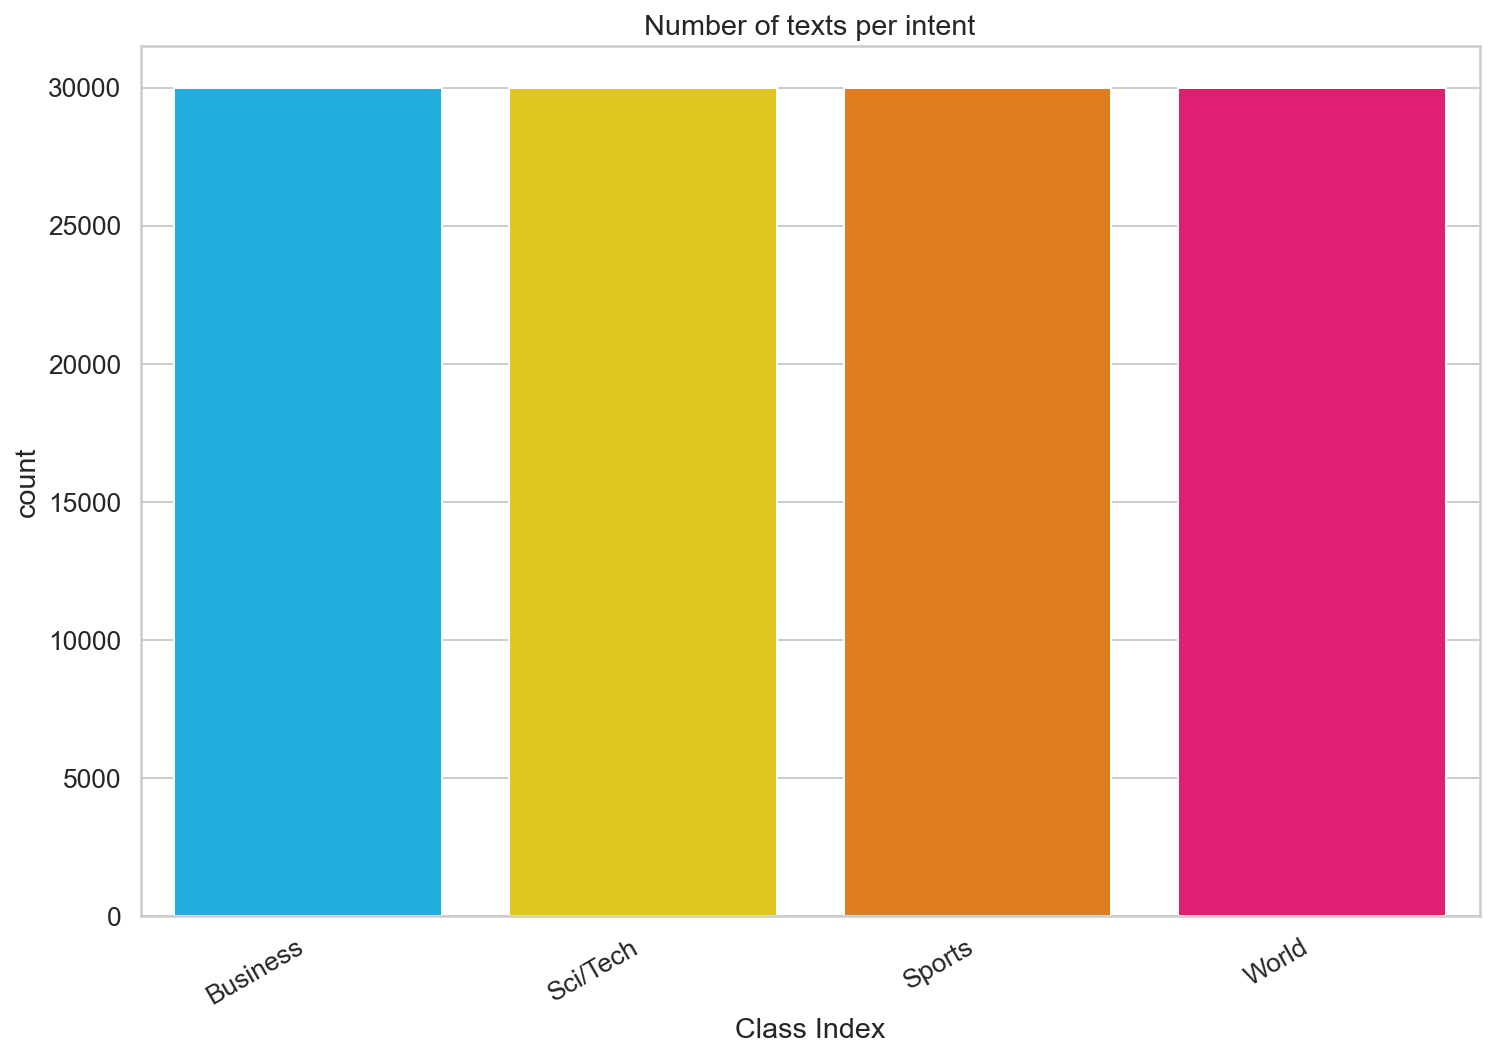

In [41]:
import seaborn as sns
chart = sns.countplot(train["Class Index"])
                      
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [42]:
test=test.drop(["Title"], axis=1)

In [43]:
train=train.drop(["Title"], axis=1)

In [44]:
train.shape

(120000, 2)

In [45]:
!pip install wget
import wget

wget.download('https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip')

100% [......................................................................] 407727028 / 407727028

'uncased_L-12_H-768_A-12 (3).zip'

In [46]:
os.makedirs("model", exist_ok=True)

In [47]:
import zipfile
with zipfile.ZipFile('uncased_L-12_H-768_A-12.zip') as zip_ref:
    zip_ref.extractall('uncased_L-12_H-768_A-12')

In [48]:
!move uncased_L-12_H-768_A-12\uncased_L-12_H-768_A-12  model

Access is denied.


In [49]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [50]:
class IntentDetectionData:
  DATA_COLUMN = "Description"
  LABEL_COLUMN = "Class Index"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [51]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [52]:
!pip install -U numpy==1.19.2
import numpy as np

  Using cached numpy-1.19.2-cp38-cp38-win_amd64.whl (13.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Rolling back uninstall of numpy
  Moving to c:\programdata\anaconda3\lib\site-packages\numpy-1.19.5.dist-info\
   from C:\ProgramData\Anaconda3\Lib\site-packages\~umpy-1.19.5.dist-info
  Moving to c:\programdata\anaconda3\lib\site-packages\numpy\.libs\libopenblas.wcdjnk7yvmpzq2me2zzhjjrj3jikndb7.gfortran-win_amd64.dll
   from C:\Users\Administrator\AppData\Local\Temp\2\pip-uninstall-48yizprw\libopenblas.wcdjnk7yvmpzq2me2zzhjjrj3jikndb7.gfortran-win_amd64.dll
  Moving to c:\programdata\anaconda3\lib\site-packages\numpy\__config__.py
   from C:\Users\Administrator\AppData\Local\Temp\2\pip-uninstall-pvxnr826\__config__.py
  Moving to c:\programdata\anaconda3\lib\site-packages\numpy\__init__.cython-30.pxd
   from C:\Users\Administrator\AppData\Local\Temp\2\pip-uninstall-pvxnr826

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\ProgramData\\Anaconda3\\Lib\\site-packages\\numpy\\.libs\\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



  Moving to c:\programdata\anaconda3\scripts\f2py.exe
   from C:\Users\Administrator\AppData\Local\Temp\2\pip-uninstall-ka7pwijn\f2py.exe


In [53]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids =keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [54]:
classes =train["Class Index"].unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=256)

120000it [01:52, 1068.72it/s]
7600it [00:06, 1090.17it/s]


max seq_len 372


In [55]:
#pip install --ignore-installed --upgrade --user tensorflow==2.4.1

In [56]:
#tf.__version__

In [57]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 256, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12\bert_model.ckpt into <bert.model.BertModelLayer object at 0x000001DDDDBE8A60> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [58]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 256)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 256, 768)          108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 3076

In [59]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [60]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14053864813657144986
]


In [61]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
import warnings
warnings.filterwarnings("ignore")
log_dir = "log/intent_detection/" +\
 datetime.datetime.now().strftime("%m-%d-%Y %T:%M%p")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(
  x=data.train_x,
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  epochs=6
)

Epoch 1/6
   8/6750 [..............................] - ETA: 52:48:58 - loss: 1.7985 - acc: 0.2697

In [ ]:
%load_ext tensorboard

In [ ]:

%tensorboard --logdir log

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [ ]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [ ]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

In [ ]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [ ]:

sentences = [
  "Harry Kane wins Premier League Power Rankings 2020/21; Lionel Messi and Romelu Lukaku among league leaders",
  "New robots can clean virus-laden surfaces so people won’t have to"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()